In [157]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import geocoder
from geopy import geocoders
import geopy.distance
from itertools import combinations
from geopy.geocoders import Nominatim

In [2]:
df = pd.read_json('city_search.json')

### Check the data

In [3]:
df.head()

,cities,session_id,unix_timestamp,user
0,"[New York NY, Newark NJ]",[X061RFWB06K9V],[1442503708],"[[{'user_id': 2024, 'joining_date': '2015-03-2..."
1,"[New York NY, Jersey City NJ, Philadelphia PA]",[5AZ2X2A9BHH5U],[1441353991],"[[{'user_id': 2853, 'joining_date': '2015-03-2..."
2,[San Antonio TX],[SHTB4IYAX4PX6],[1440843490],"[[{'user_id': 10958, 'joining_date': '2015-03-..."
3,[Edmonton AB],[JBRB8MZGTX3M4],[1427268063],"[[{'user_id': 7693, 'joining_date': '2015-03-1..."
4,"[Phoenix AZ, Houston TX]",[YJCMPURC2FL9C],[1430559067],"[[{'user_id': 7506, 'joining_date': '2015-02-2..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20022 entries, 0 to 20021
Data columns (total 4 columns):
cities            20022 non-null object
session_id        20022 non-null object
unix_timestamp    20022 non-null object
user              20022 non-null object
dtypes: object(4)
memory usage: 625.8+ KB


### Parse the data

In [5]:
user_id =[]
join_date = []
country = []
for i in range(len(df)):
    for ind, val in df['user'][i][0][0].items():
        if ind =='user_id':
            user_id.append(val)
        if ind == 'joining_date':
            join_date.append(val)
        if ind == 'country':
            country.append(val)

In [6]:
df['user_id '] = user_id
df['join_date']= join_date
df['country'] = country

In [7]:
df['cities'][1][0]

'New York NY, Jersey City NJ, Philadelphia PA'

In [8]:
cities =[]
session_id= []
unix_timestamp= []

for i in range(len(df)):
    cities.append(df['cities'][i][0])
    session_id.append(df['session_id'][i][0])
    unix_timestamp.append(df['unix_timestamp'][i][0])

df['cities'] = cities
df['session_id'] = session_id
df['unix_timestamp'] = unix_timestamp


## Question 1: There was a bug in the code and one country didn't get logged. It just shows up as an empty field (""). Can you guess which country was that? How? 

In [9]:
df.country.value_counts()

US    3876
DE    3638
UK    3555
      2820
FR    2298
ES    1953
IT    1882
Name: country, dtype: int64

In [10]:
missing_country = []
for i in range(len(df)):
    for key, val in df['user'][i][0][0].items():
        if key== 'country' and val == '':
           missing_country.append(i) 

In [11]:
df.iloc[missing_country,:].sample(10)

,cities,session_id,unix_timestamp,user,user_id,join_date,country
10594,"San Antonio TX, Vancouver BC",17QBW2N4ZMO21,1435058263,"[[{'user_id': 2775, 'joining_date': '2015-03-2...",2775,2015-03-24,
19014,Toronto ON,G5AK40YGLP8KD,1435307495,"[[{'user_id': 7628, 'joining_date': '2015-03-2...",7628,2015-03-26,
5398,"Montreal QC, OTTAWA ON, Oshawa ON",99ELUQCU16CNQ,1442552602,"[[{'user_id': 7083, 'joining_date': '2015-03-0...",7083,2015-03-08,
7074,"New York NY, Newark NJ, Philadelphia PA",P97RTPD7KX2PQ,1430363892,"[[{'user_id': 3041, 'joining_date': '2015-03-0...",3041,2015-03-09,
13196,San Diego CA,J2YHH5JNAPHPL,1440230597,"[[{'user_id': 3846, 'joining_date': '2015-03-0...",3846,2015-03-08,
7193,San Jose CA,WWGD4JINUR7FQ,1436151724,"[[{'user_id': 9190, 'joining_date': '2015-03-1...",9190,2015-03-15,
8176,"Vancouver BC, Seattle WA",WCTUDF334LKDZ,1431859383,"[[{'user_id': 8490, 'joining_date': '2015-03-2...",8490,2015-03-21,
17786,Houston TX,9DIVMBHNJQ786,1433846005,"[[{'user_id': 4102, 'joining_date': '2015-04-0...",4102,2015-04-03,
15026,San Antonio TX,P2NIAN50SZXRP,1431234359,"[[{'user_id': 5187, 'joining_date': '2015-03-3...",5187,2015-03-30,
15037,Toronto ON,A5J7Q8ZUJLDU0,1431748719,"[[{'user_id': 1179, 'joining_date': '2015-03-0...",1179,2015-03-08,


In [12]:
# Convert unix timestamp to hours in a day
df['time']= df['unix_timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

In [13]:
df['hour'] = pd.to_datetime(df['time']).apply(lambda x: x.hour)

In [14]:
df['country'].value_counts()

US    3876
DE    3638
UK    3555
      2820
FR    2298
ES    1953
IT    1882
Name: country, dtype: int64

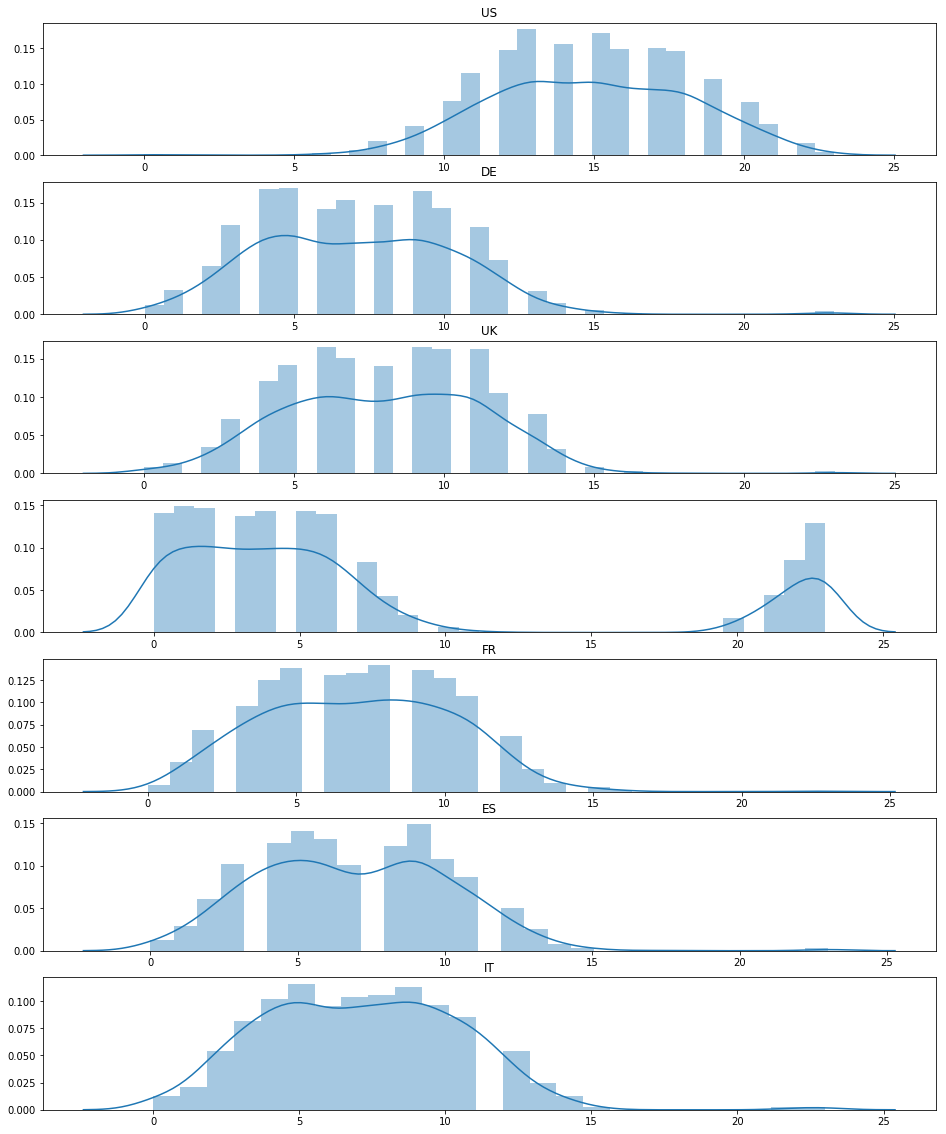

In [15]:
fig, ax = plt.subplots(7,1, figsize = (16,20))
country_list = ['US', 'DE', 'UK', '', 'FR', 'ES', 'IT']
for i in range(len(country_list)):
    sns.distplot(df[df['country']== country_list[i]]['hour'], ax = ax[i])
    ax[i].set(title = country_list[i], xlabel = '')


## Question 2: For each city, find the most likely city to be also searched for within the same session.

In [16]:
city_pairs= df['cities'].apply(lambda x: x.split(', '))

In [17]:
index = 0
maps = {}
city_list = []
for item in city_pairs:
    for city in item:
        if city not in maps:
            maps[city] = index
            index += 1
            city_list.append(city)
            
print('Unique cities:\t', len(city_list))

Unique cities:	 89


In [35]:
## create a 89 * 89 matrix
zeors_array = np.zeros( (89, 89) )

In [37]:
for i in city_pairs:
    if len(i) ==1:
        continue
    for j in range(len(i)-1):
        index1 = maps[i[j]]
        for t in range(j+1,len(i)):
            index2= maps[i[t]]
            zeors_array[index1, index2 ] +=1
            zeors_array[index2, index1] +=1
matrix_df = pd.DataFrame(zeors_array, index = city_list, columns=city_list)

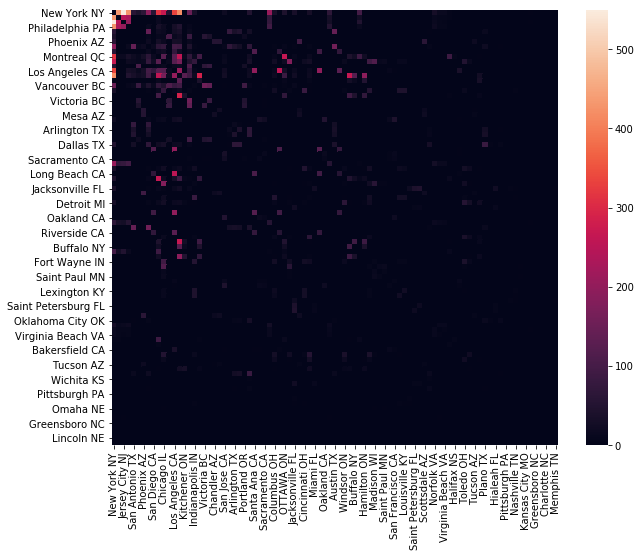

In [39]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(matrix_df, ax=ax)

In [48]:
similarities = matrix_df.apply(np.argmax, axis =0).reset_index()
similarities.columns  = ['city', 'most similar city']

In [50]:
similarities.sample(10)

,city,most similar city
77,Tulsa OK,Oklahoma City OK
36,Jacksonville FL,Tampa FL
55,Fresno CA,San Jose CA
11,Calgary AB,Vancouver BC
26,Portland OR,Vancouver BC
85,New Orleans LA,Jacksonville FL
7,Houston TX,New York NY
54,Saint Paul MN,Chicago IL
10,Chicago IL,New York NY
24,Arlington TX,Dallas TX


## Question 3 : Travel sites are browsed by two kinds of users. Users who are actually planning a trip and users who just dream about a vacation. The first ones have obviously a much higher purchasing intent. Users planning a trip often search for cities close to each other, while users who search for cities far away from each other are often just dreaming about a vacation. That is, a user searching for LA, SF and Las Vegas in the same session is much more likely to book a hotel than a user searching for NY, Paris, Kuala Lumpur (makes sense, right?). Based on this idea, come up with an algorithm that clusters sessions into two groups: high intent and low intent. Explain all assumptions you make along the way.


In [59]:
geolocator = Nominatim(user_agent="no_name")

In [160]:
# Get the Coordinates for each city and then calculate the distance between the cities
lat = []
long = []
for city in city_list:
    lat.append(geolocator.geocode(city).latitude)
    long.append(geolocator.geocode(city).longitude)

In [67]:
location_df = pd.DataFrame(list(zip(city_list, lat, long)), columns= ['city_list', 'lat', 'long'])

In [69]:
location_df.head()

,city_list,lat,long
0,New York NY,40.712728,-74.006015
1,Newark NJ,40.735657,-74.172367
2,Jersey City NJ,40.728158,-74.077642
3,Philadelphia PA,39.952724,-75.163526
4,San Antonio TX,29.424600,-98.495141


In [151]:
def search_dist(entry):
    cities = location_df[location_df['city_list'].isin(entry)]
    coords = zip(cities['lat'], cities['long'])
    def distance(x,y): return geopy.distance.distance(x, y).miles   

    max_square_distance = 0
    for pair in combinations(list(coords), 2):
        if distance(*pair) > max_square_distance:
            max_square_distance = square_distance(*pair)
    return max_square_distance

In [158]:
max_distance = df['cities'].apply(search_dist)

In [159]:
max_distance.head()

0       8.875033
1      80.530832
2       0.000000
3       0.000000
4    1016.101324
Name: cities, dtype: float64

In [161]:
df['max_distance']= max_distance

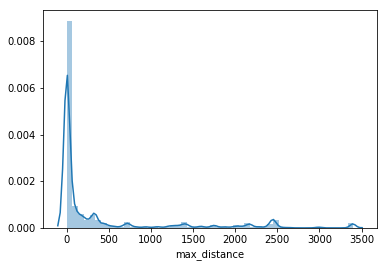

In [166]:
sns.distplot(df['max_distance'])

In [174]:
## Set the 250 miles as the cutoff point
df['intent']= np.where(df['max_distance'] >= 250, 0, 1) # if the distance is greater and equals to 250 miles, set the intent of planing trip to 0, else 1;

In [175]:
# Show some low intent search:
df[df['intent'] == 0]['cities'].sample(10)

15644                           [Houston TX, Vancouver BC]
19432                         [Los Angeles CA, Toronto ON]
12705        [Jacksonville FL, Toronto ON, Los Angeles CA]
2006                   [Montreal QC, OTTAWA ON, Oshawa ON]
11065                            [Toronto ON, New York NY]
5884                            [Vancouver BC, Chicago IL]
6924                             [New York NY, Houston TX]
18417                            [Toronto ON, Montreal QC]
14589                           [Vancouver BC, Houston TX]
8599     [Chicago IL, Madison WI, Minneapolis MN, Saint...
Name: cities, dtype: object

In [177]:
# Show some high intent search:
df[df['intent'] == 1]['cities'].sample(10)

3905                      [Montreal QC]
9268                      [New York NY]
4803                      [New York NY]
19353                     [Montreal QC]
12886                    [San Diego CA]
902                   [Indianapolis IN]
7481        [San Antonio TX, Austin TX]
18667     [New York NY, Jersey City NJ]
9223                       [Calgary AB]
4441     [Los Angeles CA, Santa Ana CA]
Name: cities, dtype: object